In [1]:
import time, os
import pylcp
import numpy as np
import scipy.constants as cts
import matplotlib.pyplot as plt
import time
from pymongo import MongoClient

In [2]:
from scipy.optimize import root_scalar

In [15]:
#Define the constants
main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000

Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 8.
z_max = 0.012/x0
z_start = 0.012/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(N=1,I=0.5,B=15496.8125/Gamma,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,gI=5.585,gS=2.0023193043622,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(J=0.5,I=0.5,
    P=+1,B=15788.2/Gamma,D=0.,H=0.,a=109./Gamma,b=-299.2/Gamma,c=274.2/Gamma,q=0., p=15./Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,
    gl=53/(2*15788.2),glprime=15/(2*15788.2),greprime=0.,return_basis=True
    )
# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [16]:
def Zeeman_function(Bz):
    ham = H0_A + Bz*Bq_A[1]
    w, v = np.linalg.eigh(ham)
    diag = np.diag(v @ ham @ v.transpose())
    return diag

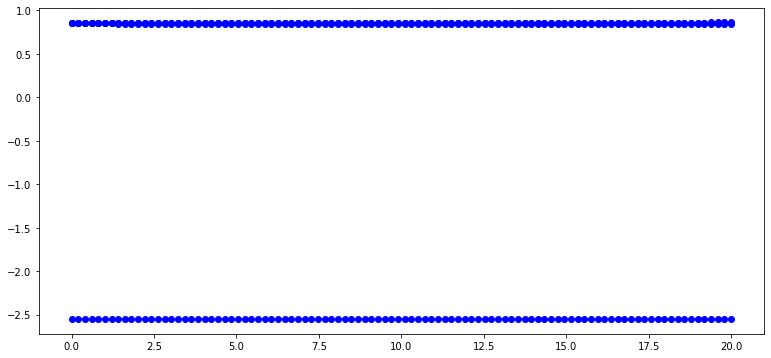

In [17]:
fig, ax = plt.subplots(1,1,figsize=(13,6))
zzz = np.linspace(0,20,100)

Zeeman_vector = np.vectorize(Zeeman_function)

for zss in zzz:
    res = Zeeman_function(zss)
    for ii in range(len(res)):
        ax.plot(zss,res[ii]*Gamma,"bo")

In [18]:
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

mag_field_grad = 2.*1000*x0
magField = pylcp.quadrupoleMagneticField(mag_field_grad)

def Fixed_detune_MgF_MOT(s):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=+1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.15,pol=+1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=-1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [19]:
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

mag_field_grad = 2.*1000*x0
magField = pylcp.quadrupoleMagneticField(mag_field_grad)

def Fixed_detune_MgF_MOT2(s):
    laserBeams = pylcp.laserBeams()
    def Gaussian_Beam_Axis(R,waist,ax):
        if ax==0:
            return np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)
        elif ax==1:
            return np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)
        elif ax==2:
            return np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)

    d1 =-0.5
    d2 = -0.5
    d3 = -0.15
    d4 = -0.5


    for ii, Eg_i in enumerate(E_X):
        if ii==0:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d1,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d1,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d1,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d1,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*np.array([0,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d1,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*np.array([0,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d1,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
        elif ii==1:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d2,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d2,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d2,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d2,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*np.array([0,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d2,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*np.array([0,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d2,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam) 
        elif ii==2:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d3,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d3,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d3,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d3,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*np.array([0,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d3,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*np.array([0,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d3,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
        else:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d4,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d4,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':np.array([1,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d4,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':np.array([1,0,0]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d4,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*np.array([0,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d4,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*np.array([0,0,1]),"pol_coord":"spherical",'delta':(E_A[-1]-Eg_i)+d4,
                                             's' : s, "wb" : waist}],beam_type=pylcp.gaussianBeam)

    return laserBeams

Text(0.5, 1.0, '$a$ vs $v_z$')

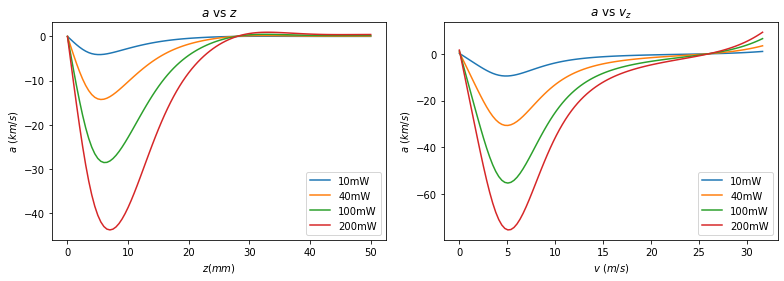

In [20]:
# The detunings used in the PRAs:
dets = np.array([-0.25, -0.5, -1, -2])
P = np.array([0.010, 0.040, 0.1, 0.2])
intensities = 2.*P/(np.pi*0.012**2)/Isat
# Make the axis:
z = np.linspace(0, 50/x0/1000, 101)
v = np.linspace(0., 4., 101)

fig,ax = plt.subplots(1,2,figsize=(13,4))    
for jj, intensity in enumerate(intensities):
    laserBeams = Fixed_detune_MgF_MOT(intensity)
    trap = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=1)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-12*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[0].plot(z*x0*1000, trap.profile['Fz'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])}mW')
    ax[1].plot(v*x0/t0, trap.profile['Fv'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])}mW')
ax[0].set_xlabel('$z (mm)$')
ax[0].set_ylabel('$a\ (km/s)$')
ax[1].set_xlabel('$v\ (m/s)$')
ax[1].set_ylabel("$a\ (km/s)$")
ax[0].legend()
ax[1].legend()
fig.subplots_adjust(hspace=0.33, wspace=0.175)
ax[0].set_title("$a$ vs $z$")
ax[1].set_title("$a$ vs $v_z$")


# fig.savefig('D:/migration/picture/0520/MgF_force.png')

In [342]:
zz = np.linspace(-1*z_max,z_max,100)
vv = np.linspace(-1*v_max,v_max,100)
Z,V = np.meshgrid(zz,vv)

laserBeams = Fixed_detune_MgF_MOT(intensities[3])
magField = pylcp.quadrupoleMagneticField(mag_field_grad)
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [343]:
rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=1)

Completed in 12.58 s.                                               


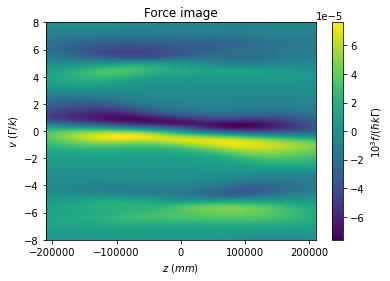

In [344]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['F'].F[2]/mass, origin='lower',
           extent=(np.amin(zz), np.amax(zz),
                   (np.amin(vv)), (np.amax(vv))),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$10^3f/(\hbar k \Gamma)$')
ax.set_xlabel('$z\ (mm)$')
ax.set_ylabel('$v\ (\Gamma /k)$')
ax.set_title('Force image')
fig.subplots_adjust(left=0.12,right=0.9)

# fig.savefig('20210614_6.png')/

In [349]:
# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=1e-1):
    if y[-4]<threshold:
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=4.5):
    if y[-4]>threshold:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

In [352]:
sols_rate = list()

start = time.time()

v_eval = np.linspace(1,3,11)

for v0a in v_eval:
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,-1*z_start]),np.array([0.,0.,v0a]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [captured_condition,lost_condition],progress_bar = 1,method='LSODA')
    sols_rate.append(rateeq.sol)

Completed in 3.40 s.                                                    
Completed in 3.45 s.                                                    
Completed in 3.58 s.                                                    
Completed in 3.51 s.                                                    
Completed in 3.80 s.                                                    
Completed in 3.65 s.                                                    
Completed in 3.49 s.                                                    
Completed in 3.76 s.                                                    
Completed in 3.68 s.                                                    
Completed in 3.91 s.                                                    
Completed in 4.32 s.                                                    


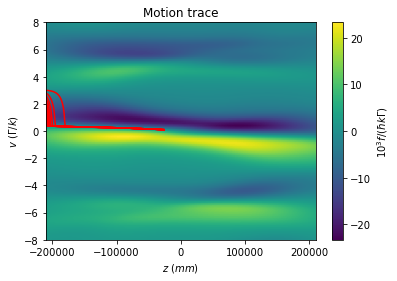

In [353]:
fig, ax = plt.subplots(1, 1)
plt.imshow(1e3*rateeq.profile['F'].F[2], origin='lower',
           extent=(np.amin(zz), np.amax(zz),
                   (np.amin(vv)), (np.amax(vv))),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$10^3f/(\hbar k \Gamma)$')
ax.set_xlabel('$z\ (mm)$')
ax.set_ylabel('$v\ (\Gamma /k)$')
ax.set_title('Motion trace')
ax.set_xlim(-1*z_max,z_max)
ax.set_ylim(-1*v_max,v_max)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2],sol.v[2], 'r')

# fig.savefig('./picture/20210614_7.png')

In [11]:
print(time.time()-start)

14.118167638778687


In [57]:
for sol in sols_rate:
    if len(sol.t_events[0])==1:
        print('trapped')
    elif len(sol.t_events[1])==1:
        print('lost')
    else:
        print('i don`t know')

trapped
trapped
trapped
trapped
trapped
trapped
trapped
trapped
trapped
trapped
trapped
lost
lost
lost
lost


In [58]:
def is_trapped(v0,z0,eqn, captured_condition, lost_condition, tmax=1000, max_step=np.inf, **kwargs):
    eqn.set_initial_position_and_velocity(np.array([0.,0.,z0]),np.array([0.,0.,v0]))
    if isinstance(eqn,pylcp.rateeq):
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    eqn.evolve_motion([0.,tmax],events = [captured_condition,lost_condition],max_step = max_step)
    
    if len(eqn.sol.t_events[0]) == 1:
        return 1
    else:
        return -1

In [61]:
from scipy.optimize import root_scalar
start = time.time()
vc = root_scalar(is_trapped,bracket=[3.0,3.5],args = (-1*z_start,rateeq,captured_condition,lost_condition,2000000),method = 'brentq')

vc

      converged: True
           flag: 'converged'
 function_calls: 40
     iterations: 39
           root: 3.0640292643020075

In [15]:
# print(time.time()-start)

In [16]:
# vc.root*v0

In [17]:
# # The detunings used in the PRAs:
# dets = np.array([-0.25, -0.5, -1, -2])
# P = np.array([0.010, 0.040, 0.1, 0.2])
# intensities = 2.*P/(np.pi*0.012**2)/Isat
# # Make the axis:
# z = np.linspace(0, 50., 101)
# v = np.linspace(0., 4., 101)

# fig,ax = plt.subplots(1,2,figsize=(13,4))    
# for jj, intensity in enumerate(intensities):
#     laserBeams = Fixed_detune_MgF_MOT(intensity)
#     trap = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=0)
#     trap.generate_force_profile(
#         [np.zeros(z.shape), np.zeros(z.shape), z],
#         [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)*3],
#         name='Fz')
#     trap.generate_force_profile(
#         [np.zeros(z.shape), np.zeros(z.shape), z],
#         [np.zeros(z.shape), np.zeros(z.shape), np.ones(z.shape)*0],
#         name='Fv')
#     ax[0].plot(z, trap.profile['Fz'].F[2]/mass*x0/t0**2*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])}mW')
#     ax[1].plot(v*x0/t0, trap.profile['Fv'].F[2]/mass*x0/t0**2*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])}mW')
# ax[0].set_xlabel('$z (mm)$')
# ax[0].set_ylabel('$a\ (km/s)$')
# ax[1].set_xlabel('$v\ (m/s)$')
# ax[0].legend()
# ax[1].legend()
# fig.subplots_adjust(hspace=0.33, wspace=0.175)

AttributeError: F

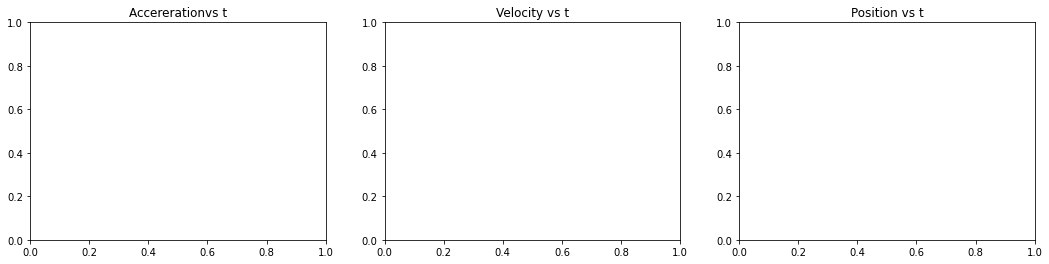

In [18]:
sols = sols_rate[0]
fig, ax = plt.subplots(1,2,figsize=(14,5))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[0]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[0]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])

fig.savefig('./picture/20210614_4.png')

In [ ]:
sols = sols_rate[-1]
fig, ax = plt.subplots(1,2,figsize=(14,5))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[0]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[0]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])
fig.savefig('./picture/20210614_5.png')

In [ ]:
for ii, a in enumerate(sols.v[2]):
    if a>0.2:
        pass
    else:
        print(ii)
        break